In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))
from models import UNetDiffusion, UNet_diffusion_normal, UNet_diffusion_sample, UNet_diffusion_mixednormal, UNet_diffusion_mvnormal
import torch
from models import Diffusion, generate_diffusion_samples_low_dimensional, DistributionalDiffusion
import matplotlib.pyplot as plt
import numpy as np
from data import PDE1D
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


from cmap import Colormap
plt.rcParams['image.cmap']= 'cividis'
cmap = Colormap('seaborn:icefire').to_mpl()
device = "cuda"

In [2]:
# Shape [B,C,D,n_t, M]
truth = np.load("trajectories/KS_truth.npy")
deterministic = np.load("trajectories/KS_deterministic.npy")
normal = np.load("trajectories/KS_normal.npy")
mixednormal = nuth = np.load("trajectories/KS_mixednormal.npy")
mvnormal = np.load("trajectories/KS_mvnormal.npy")
sample = np.load("trajectories/KS_sample.npy")

In [3]:
ticksize = 29
legendsize = 32
axissize = 31
titlesize = 34
plt.style.use(["science"])

# Plot Error, Mean and Standard deviation

In [4]:
def plot_predictions(truth, pred,name, b=2, s=10):
    fig, axs = plt.subplots(1, 3, figsize=(20, 3), layout = "constrained")
    im1 = axs[0].pcolormesh((truth[b,0,2:].T-pred[b,0].mean(axis = -1))**2, cmap = cmap, vmax = 15, rasterized = True)
    axs[0].set_title("Squared error", fontsize = titlesize)
    cb1 = fig.colorbar(im1, ax = axs[0])

    im3 = axs[1].pcolormesh(pred[b,0,:,:,:].mean(axis = -1), cmap = cmap, vmin = -2.5, vmax = 2.5, rasterized = True)
    axs[1].set_title("Mean prediction", fontsize = titlesize)
    cb2 = fig.colorbar(im3, ax = axs[1])

    im4 = axs[2].pcolormesh(pred[b,0].std(axis = -1), vmax = 1.7, rasterized = True)
    axs[2].set_title("Standard deviation", fontsize = titlesize)
    cb3 = fig.colorbar(im4, ax = axs[2])

    for ax in axs:
        ax.set_xlabel("s", fontsize = axissize)  
        ax.tick_params(axis="both", which="major", labelsize=ticksize)

    axs[0].set_ylabel("x", fontsize = axissize)
    for cb in [cb1,cb2,cb3]:
        cb.ax.tick_params(labelsize=legendsize)


    #plt.savefig(f"plots/KS_single_{name}.pdf", bbox_inches = "tight")

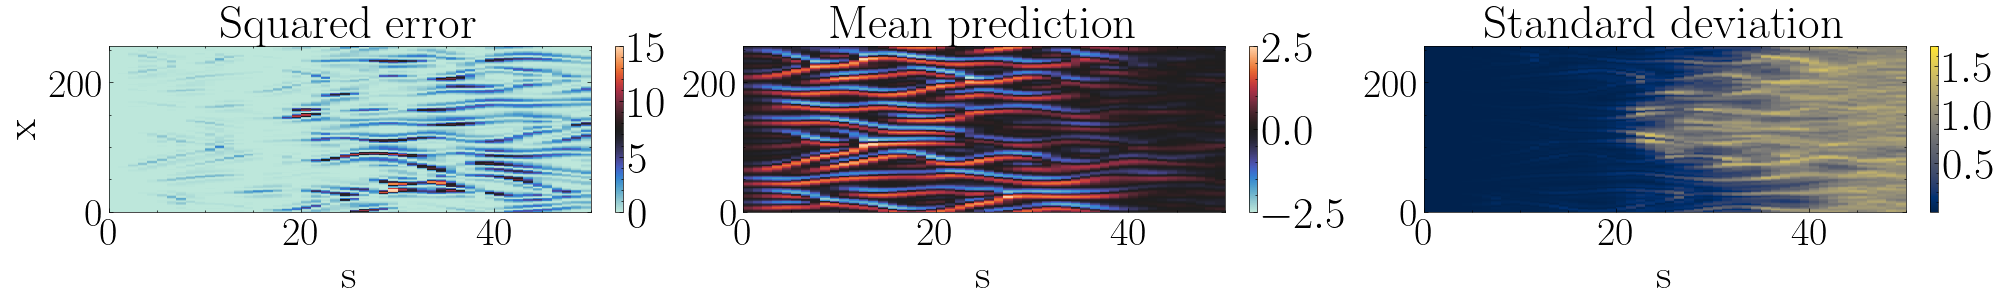

In [5]:
plot_predictions(truth, deterministic, "deterministic")

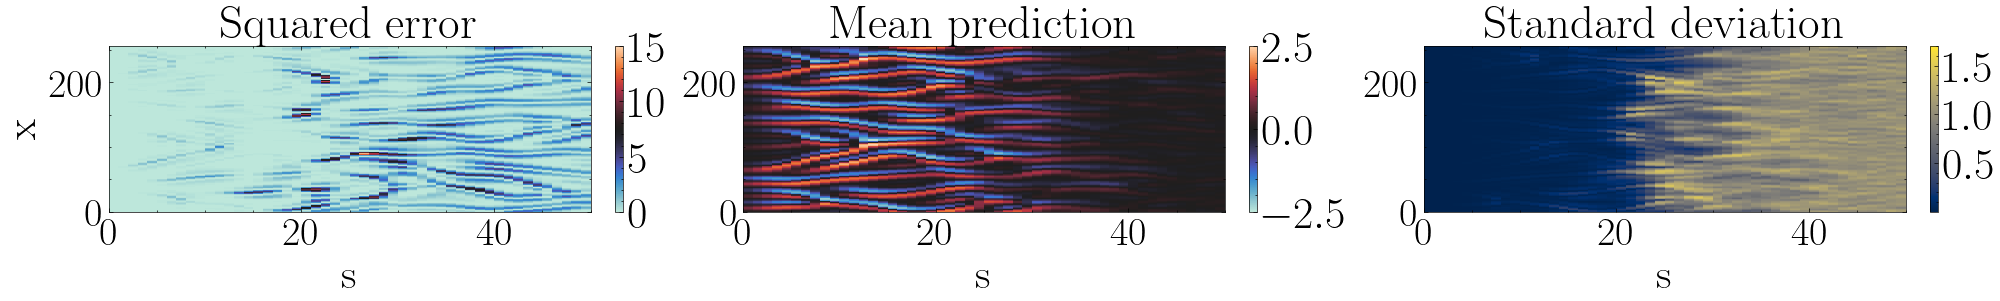

In [6]:
plot_predictions(truth, mixednormal,"mixednormal")

# Multiple plots

In [7]:
ticksize = 29
legendsize = 32
axissize = 31
titlesize = 34
plt.style.use(["science"])

In [8]:
def plot_predictions(truth, pred,name, b=4, s=25):

    fig = plt.figure(figsize=(25, 5))

    # Outer grid: 2 rows × 2 columns
    outer = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[1, 2], wspace=0.1, hspace=0.15)

    # Right block: a 2×2 inside the right column
    right_gs = gridspec.GridSpecFromSubplotSpec(
        2, 2, subplot_spec=outer[:, 1], wspace=0.1, hspace=0.3
    )

    axs = [
        fig.add_subplot(right_gs[0, 0]),
        fig.add_subplot(right_gs[0, 1]),
        fig.add_subplot(right_gs[1, 0]),
        fig.add_subplot(right_gs[1, 1]),
    ]

    cbs = []

    # Left subplot: put in the middle between top and bottom
    # → we compute its size from one right subplot and align manually
    pos_top = axs[0].get_position()
    pos_bottom = axs[2].get_position()

    # Same height as one of the right plots
    height = pos_top.height
    # Same vertical center as the 2×2 block
    center_y = (pos_top.y0 + pos_bottom.y1) / 2

    # Manually add left axis with matching size
    ax_left = fig.add_axes([0.12, center_y - height/2, pos_top.width, height])

    # --- Plots ---
    vmin_truth = -2.5
    vmax_truth = 2.5
    im1 = axs[0].pcolormesh(pred[b,0,:,:,s], cmap = cmap, rasterized = True, vmin = vmin_truth, vmax = vmax_truth)
    axs[0].set_title("Sample trajectory", fontsize = titlesize)
    cbs.append(fig.colorbar(im1, ax = axs[0], pad = 0.02))

    im3 = axs[1].pcolormesh((truth[b,0,2:].T-pred[b,0].mean(axis = -1))**2, cmap = cmap, rasterized = True, vmax = 16)
    axs[1].set_title("Squared error", fontsize = titlesize)
    cbs.append(fig.colorbar(im3, ax=axs[1], pad = 0.02))

    im2 = axs[2].pcolormesh(pred[b,0].mean(axis=-1), cmap=cmap, rasterized = True, vmin = vmin_truth, vmax = vmax_truth)
    axs[2].set_title("Mean prediction", fontsize = titlesize)
    cbs.append(fig.colorbar(im2, ax=axs[2], pad = 0.02))

    im4 = axs[3].pcolormesh(pred[b,0].std(axis = -1), cmap="cividis", rasterized = True, vmax = 1.7)
    axs[3].set_title("Standard deviation", fontsize = titlesize)
    cbs.append(fig.colorbar(im4, ax=axs[3], pad = 0.02))

    # Left plot
    im_left = ax_left.pcolormesh(truth[b,0,2:].T, cmap=cmap, rasterized = True, vmin = vmin_truth, vmax = vmax_truth)
    ax_left.set_title("Ground truth", fontsize = titlesize)
    cbs.append(fig.colorbar(im_left, ax=ax_left, pad = 0.02))

    # Add labels
    # Hide x-ticks on the top row
    for ax in [axs[0], axs[1]]:
        ax.set_xticklabels([])
        ax.set_xlabel("")

    # Hide y-ticks on the right column
    for ax in [axs[1], axs[3]]:
        ax.set_yticklabels([])
        ax.set_ylabel("")

    # Add labels only where needed
    axs[2].set_xlabel("s", fontsize = axissize)   # bottom left
    axs[3].set_xlabel("s", fontsize = axissize)   # bottom right
    axs[0].set_ylabel("x", fontsize = axissize)   # top left
    axs[2].set_ylabel("x", fontsize = axissize)   # bottom left

    # Do the same for the left (truth) plot
    ax_left.set_xlabel("s", fontsize = axissize)
    ax_left.set_ylabel("x", fontsize = axissize)

    for ax in [ax_left] + [axs[0], axs[2]]:
        ax.yaxis.set_major_locator(plt.MaxNLocator(3))

    for ax in [ax_left] + axs:
        ax.tick_params(axis="both", which="major", labelsize=ticksize)

    for ax in [ax_left] + [axs[2], axs[3]]:
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))

    for cb in cbs:
        cb.ax.tick_params(labelsize=legendsize)

    plt.savefig(f"plots/KS_multiple_{name}.pdf", bbox_inches = "tight")

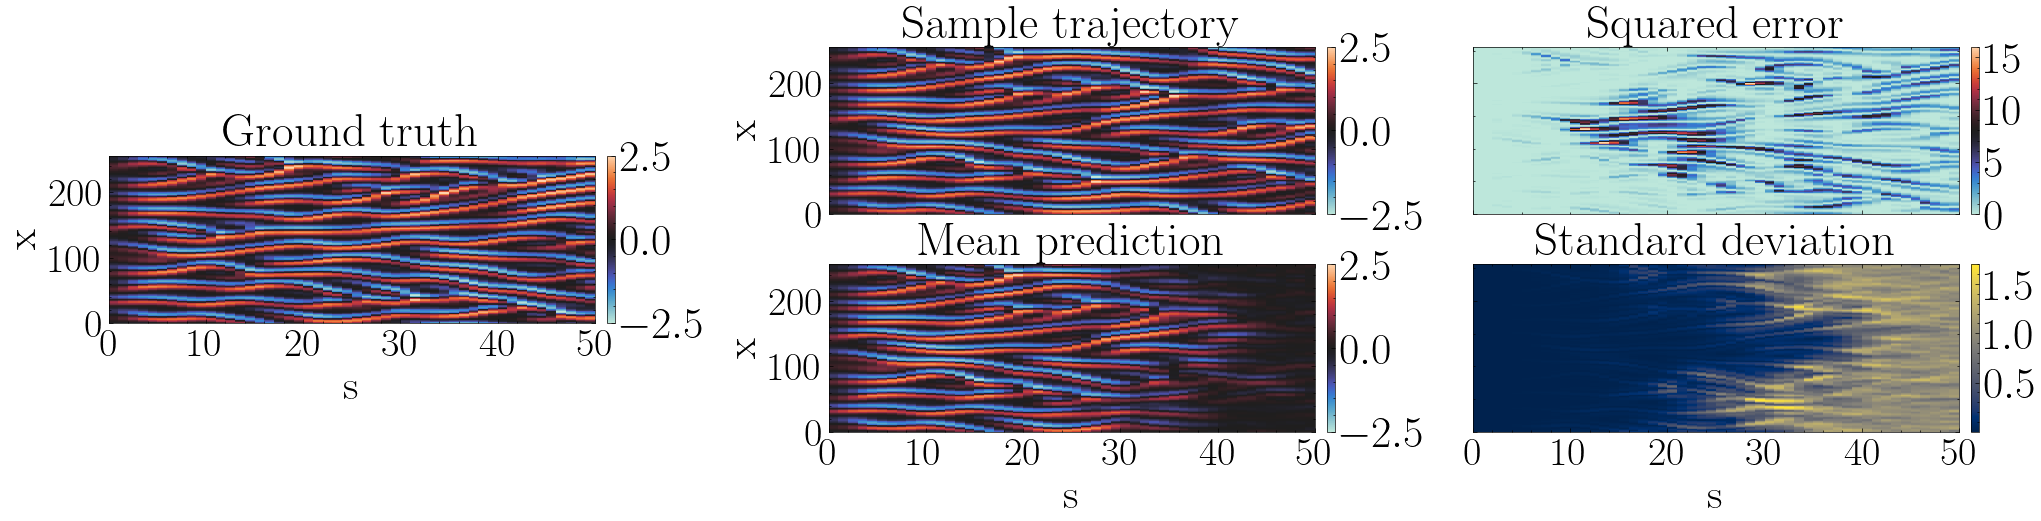

In [9]:
plot_predictions(truth, deterministic, "deterministic")

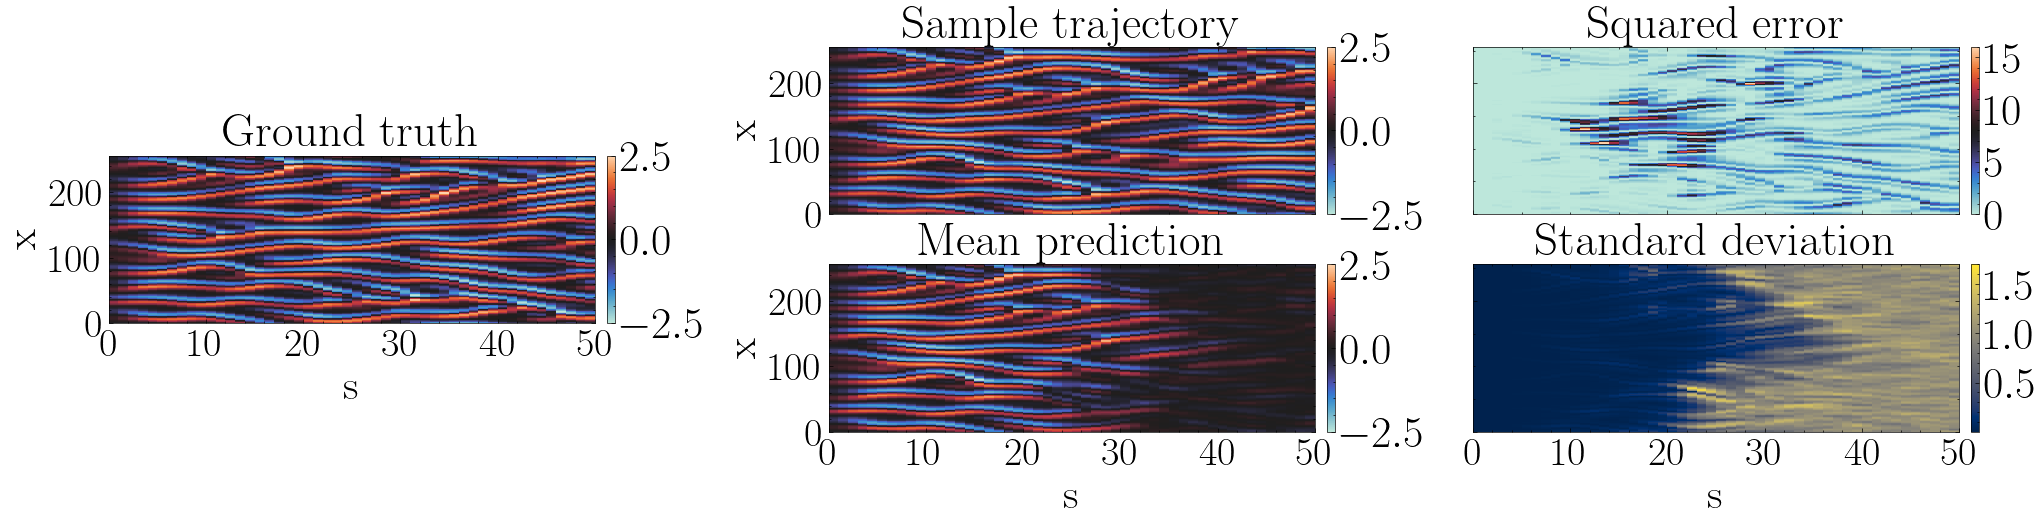

In [10]:
plot_predictions(truth, normal, "normal")

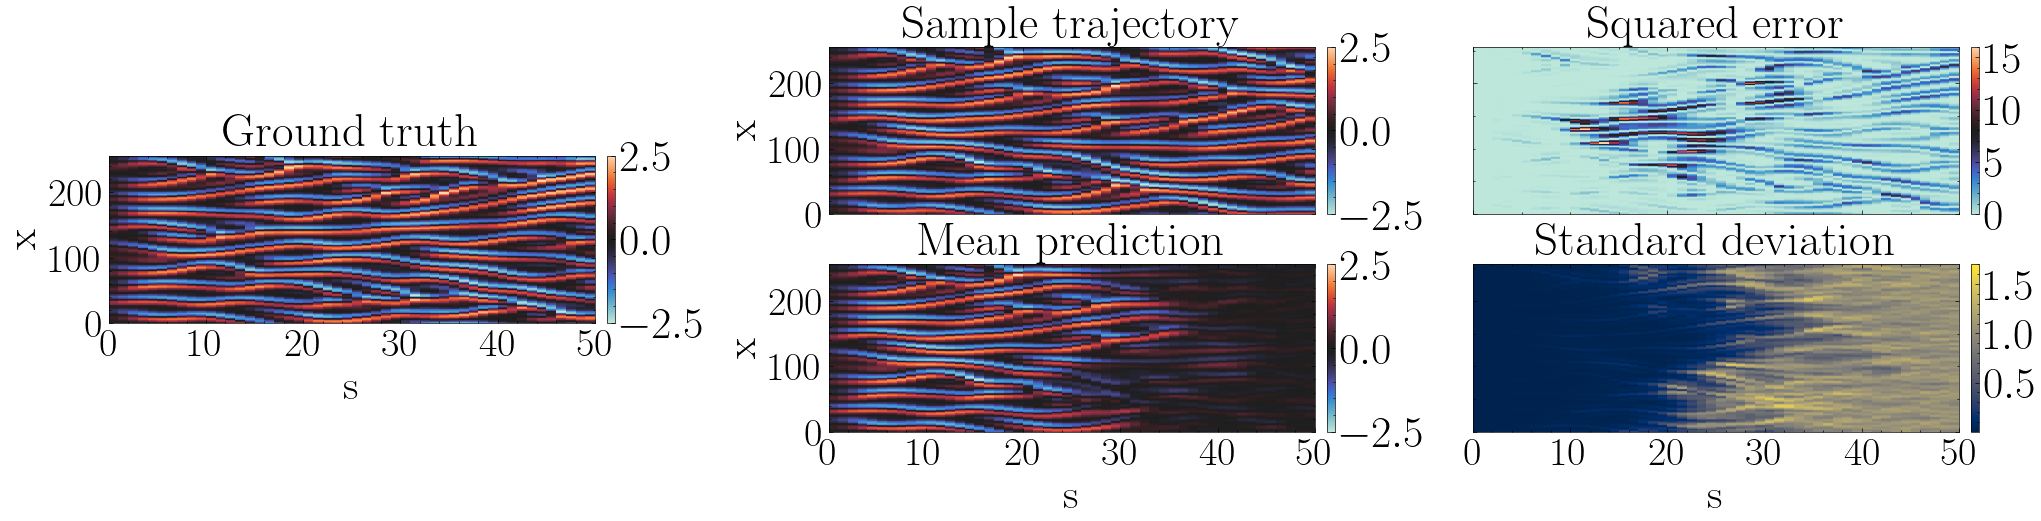

In [11]:
plot_predictions(truth, mixednormal, "mixednormal")

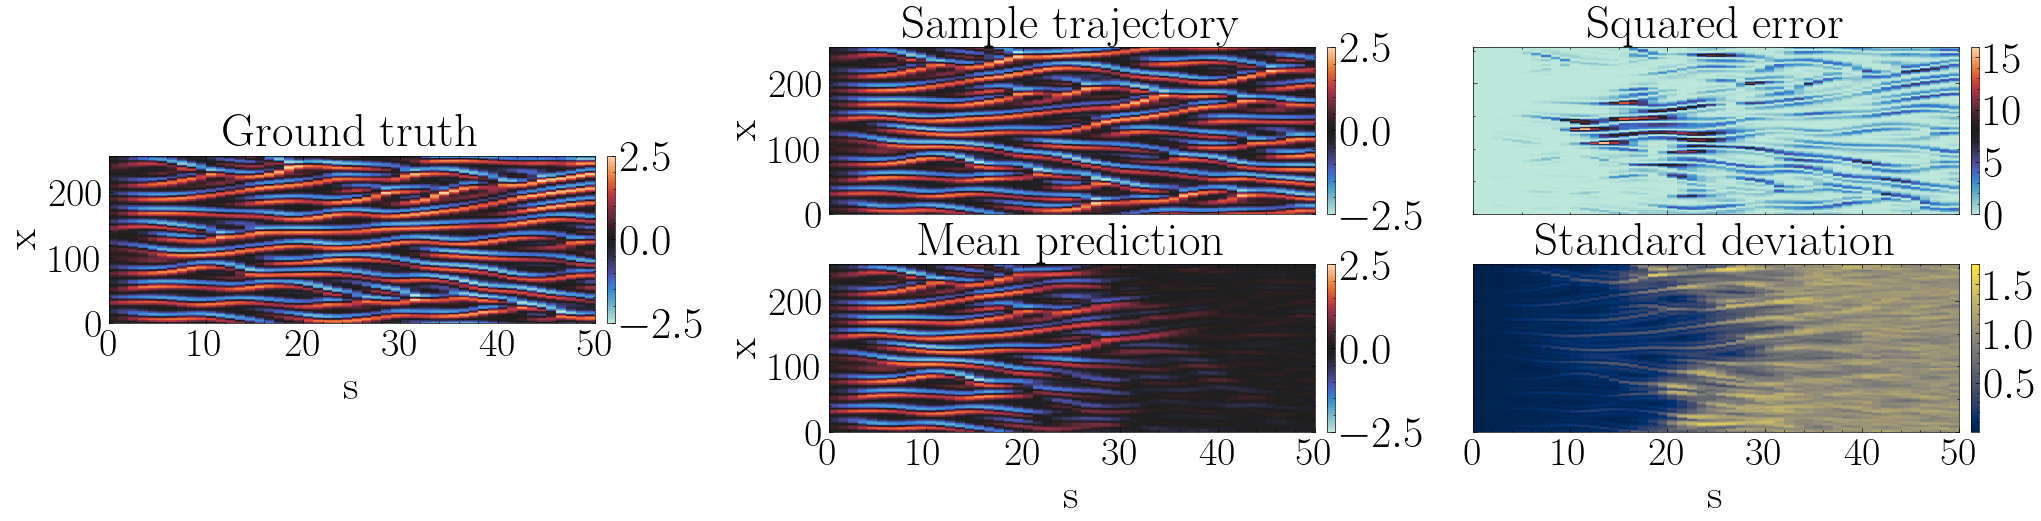

In [12]:
plot_predictions(truth, mvnormal, "mvnormal")

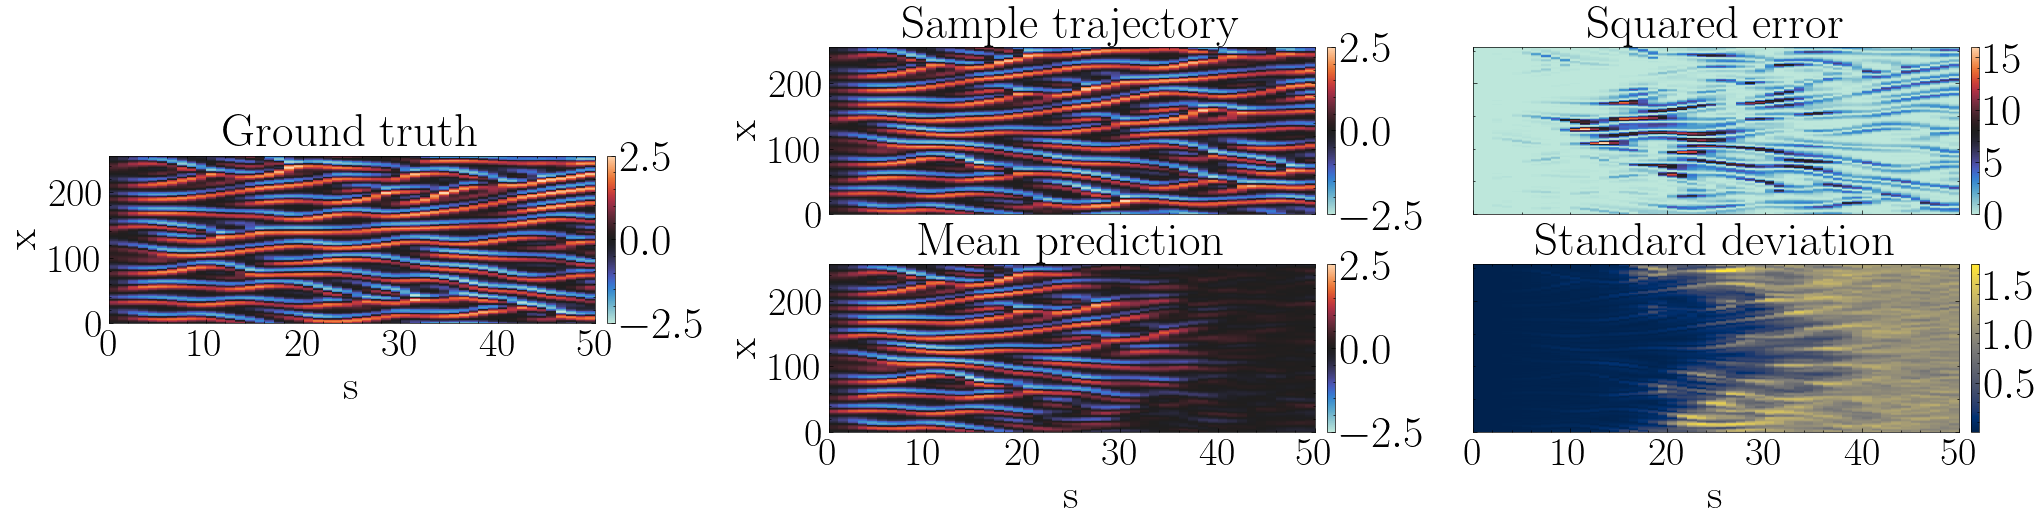

In [13]:
plot_predictions(truth, sample, "sample")